In [1]:
import numpy as np
import pylab as pb
import GPy
import copy as cp

import pickle

from cassL import camb_interface as ci
from cassL import generate_emu_data as ged
from cassL import user_interface as ui

regenerate = True

pb.ion()

file_base = ""

In [2]:
assert False, "You should give the emulator a new name instead of over-writing."
emu_vlabel = "Hz1"

In [3]:
# X_raw = np.load(file_base + "hc_massless_pred_actual.npy", allow_pickle=True)
# Y_raw = np.load(file_base + "samples_massless_pred.npy", allow_pickle=True)

# We don't use the emu_vlabel variable in the following code because the lhc
# version has decoupled from the emulator version.
X_raw = np.load(file_base + "hc_backup_i4999_h1_unit_train.npy",
                allow_pickle=True)
Y_raw = np.load(file_base + "samples_backup_i4999_h1_unit_train.npy",
                allow_pickle=True)

In [4]:
scales = np.load("standard_k.npy", allow_pickle=True)

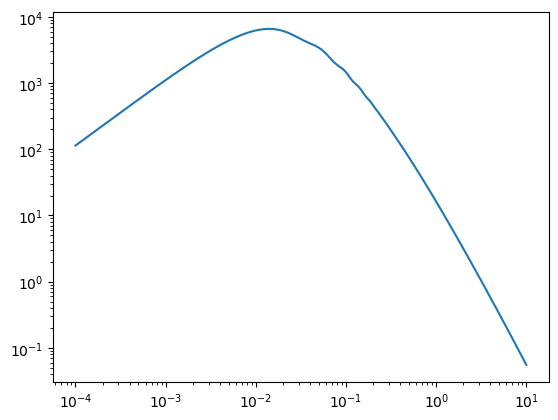

In [5]:
# This plot only serves to make sure that the first row actually describes a
# function.
pb.loglog(scales, Y_raw[0])

In [6]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [7]:
# Now the goal is to compute summary statistics on Y for each value k
Ylog = np.log(Y)
ymu = np.mean(Ylog, axis=0)
ymu.shape
ystdev = np.std(Ylog, axis=0)
ystdev.shape

(300,)

In [8]:
# now normalize the data with these summary statistics
Y_normalized = cp.deepcopy(Ylog)

for i in range(len(Y)):
    Y_normalized[i] -= ymu
    Y_normalized[i] /= ystdev

In [9]:
par_ranges = ui.get_param_ranges(massive_neutrinos=False)

In [10]:
xmin = np.array([])
xrange = np.array([])

for key in par_ranges.keys():
    xmin = np.append(xmin, par_ranges[key][0])
    xrange = np.append(xrange, par_ranges[key][1] - par_ranges[key][0])

print(xmin)
print(xrange)

[0.0205 0.085  0.92   0.2   ]
[0.00365 0.07    0.09    0.8    ]


In [11]:
def inverse_ytransform(raw_prediction):
    return np.exp(raw_prediction * ystdev + ymu)

In [12]:
# This transforms from a cosmological configuration to an LHC coordinate,
# i.e. the input format that the emulator expects.
def xtransform(configuration):
    return (configuration - xmin) / xrange

In [13]:
print(X.shape, Y_normalized.shape)

(5000, 4) (5000, 300)


In [14]:
m0 = ci.specify_neutrino_mass(ci.cosm.iloc[0], 0, 0)

In [15]:
# We'll need to check our work using CAMB
p_true_interpolator = ci.andrea_interpolator(m0)#,
#    redshifts=[0], kmax=10)
p_m0truth = np.array([p_true_interpolator.P(0, k) for k in scales])

s_m0truth = ci.s12_from_interpolator(p_true_interpolator, 0)

m0['sigma12'] = s_m0truth

print(s_m0truth)

nnu_massive: 0
0.8246417529534887


In [16]:
p_m0truth2, actual_sigma12, best_z = ged.interpolate_cell(m0, scales,
    using_andrea_code=False)

In [17]:
kernel = GPy.kern.RBF(input_dim=4, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X, Y_normalized, kernel)

In [18]:
if regenerate:
    m.constrain_positive('') # '' is a regex matching all parameter names
    m.optimize()

    m.ymu = ymu
    m.ystdev = ystdev
    m.xmin = xmin
    m.xrange = xrange
    pickle.dump(m, open("analyses/massless_emulator_" + emu_vlabel + \
                        ".cle", "wb"), protocol=5) 
else:
    m = pickle.load(open("analyses/massless_emulator_" + emu_vlabel + \
                         ".cle", "rb"))

In [19]:
# Remember that the structure of an hc entry is DIFFERENT NOW
# omb, omc, ns, s12, As, omnu
x = np.array([np.array([
    m0['ombh2'], m0['omch2'], m0['n_s'], s_m0truth
])])
x

array([[0.022445  , 0.120567  , 0.96      , 0.82464175]])

In [20]:
guess, uncertainties = m.predict(xtransform(x))

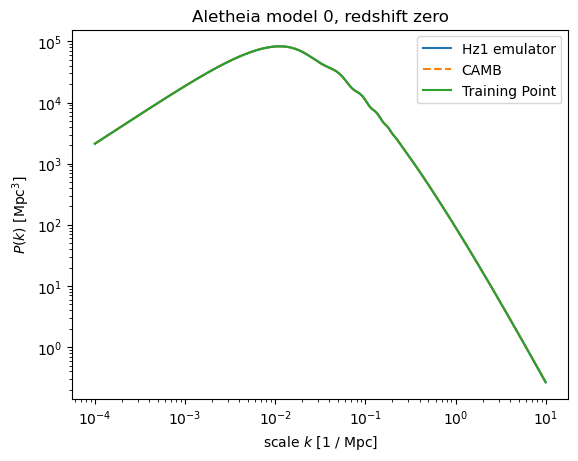

In [21]:
pb.plot(scales, inverse_ytransform(guess[0]), label=emu_vlabel + " emulator")
pb.loglog(scales, p_m0truth, label="CAMB", linestyle='dashed')
pb.loglog(scales, p_m0truth2, label="Training Point")#, linestyle='dashed')
pb.title("Aletheia model 0, redshift zero")
pb.ylabel('$P(k)$ [Mpc$^3$]')
pb.xlabel('scale $k$ [1 / Mpc]')
pb.legend()

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

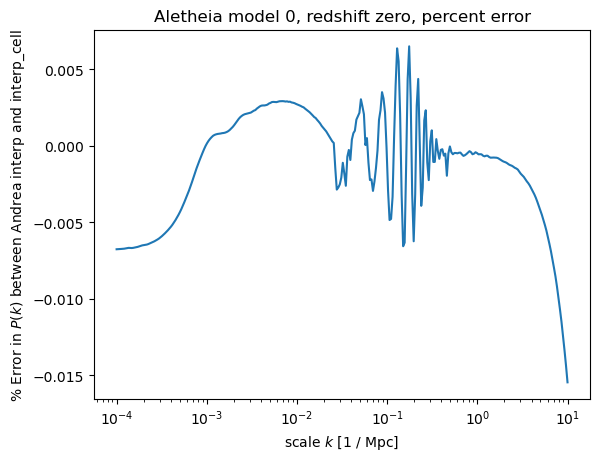

In [22]:
pb.plot(scales,
    ui.percent_error(p_m0truth, p_m0truth2))
pb.xscale('log')
pb.title("Aletheia model 0, redshift zero, percent error")
pb.ylabel('% Error in $P(k)$ between Andrea interp and interp_cell')
pb.xlabel('scale $k$ [1 / Mpc]')
# pb.savefig("../../plots/emulator/performance/massive_m0_G5.png")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

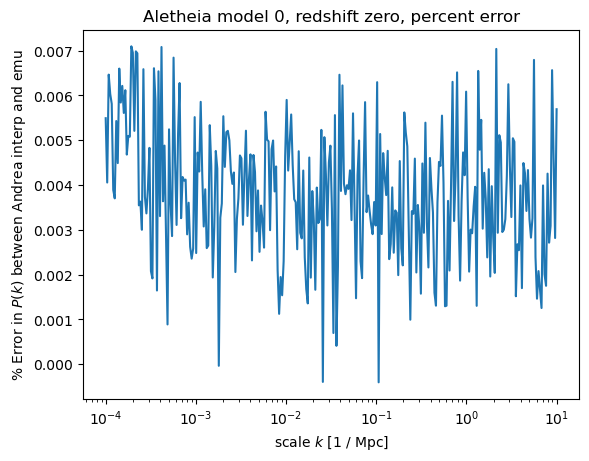

In [23]:
pb.plot(scales,
    ui.percent_error(p_m0truth2, inverse_ytransform(guess[0])))
pb.xscale('log')
pb.title("Aletheia model 0, redshift zero, percent error")
pb.ylabel('% Error in $P(k)$ between Andrea interp and emu')
pb.xlabel('scale $k$ [1 / Mpc]')
# pb.savefig("../../plots/emulator/performance/massive_m0_G5.png")

In [24]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_ns = np.array([np.array([
    0.022445, 0.120567, 1.01, 0.82466774
])])
guess_hi_ns, uncertainties_hi_ns = m.predict(xtransform(x_hi_ns))
x_lo_ns = np.array([np.array([
    0.022445, 0.120567, 0.92, 0.82466774
])])
guess_lo_ns, uncertainties_lo_ns = m.predict(xtransform(x_lo_ns))


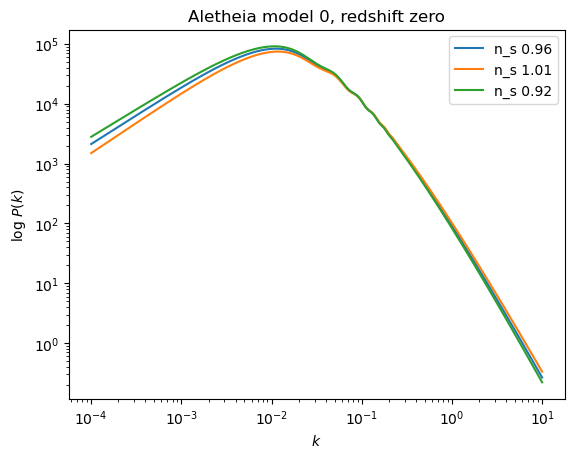

In [25]:
pb.loglog(scales, inverse_ytransform(guess[0]), label="n_s 0.96")
pb.loglog(scales, inverse_ytransform(guess_hi_ns[0]), label="n_s 1.01")
pb.loglog(scales, inverse_ytransform(guess_lo_ns[0]), label="n_s 0.92")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [26]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_omb = np.array([np.array([
    0.02415, 0.120567, 0.96, 0.82466774
])])
guess_hi_omb, uncertainties_hi_omb = m.predict(xtransform(x_hi_omb))

x_lo_omb = np.array([np.array([
    0.0205, 0.120567, 0.96, 0.82466774
])])
guess_lo_omb, uncertainties_lo_omb = m.predict(xtransform(x_lo_omb))


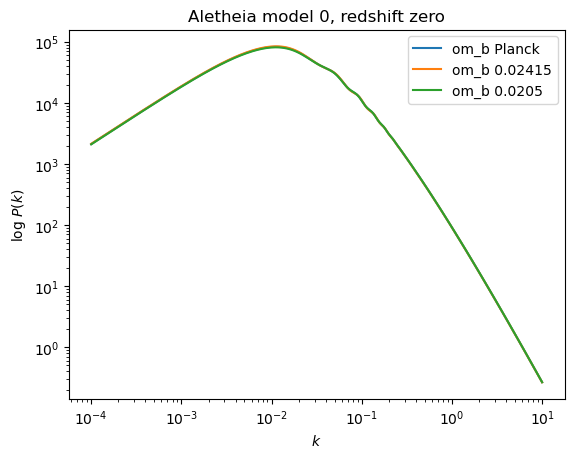

In [27]:
pb.loglog(scales, inverse_ytransform(guess[0]),
        label="om_b Planck")
pb.loglog(scales, inverse_ytransform(guess_hi_omb[0]),
        label="om_b 0.02415")
pb.loglog(scales, inverse_ytransform(guess_lo_omb[0]),
        label="om_b 0.0205")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [28]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_omc = np.array([np.array([
    0.022445, 0.155, 0.96, 0.82466774
])])
guess_hi_omc, uncertainties_hi_omc = m.predict(xtransform(x_hi_omc))

x_lo_omc = np.array([np.array([
    0.022445, 0.085, 0.96, 0.82466774
])])
guess_lo_omc, uncertainties_lo_omc = m.predict(xtransform(x_lo_omc))


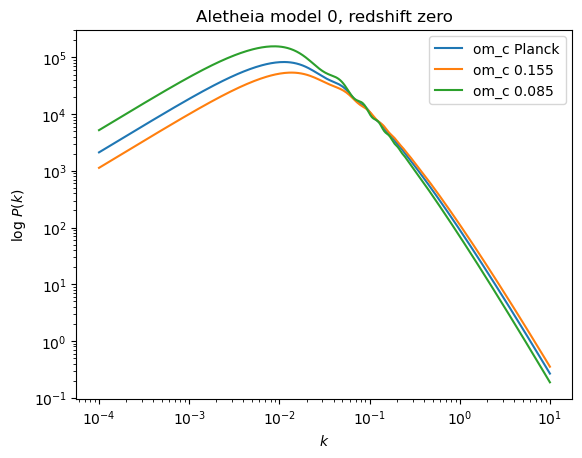

In [29]:
pb.loglog(scales, inverse_ytransform(guess[0]),
        label="om_c Planck")
pb.loglog(scales, inverse_ytransform(guess_hi_omc[0]),
        label="om_c 0.155")
pb.loglog(scales, inverse_ytransform(guess_lo_omc[0]),
        label="om_c 0.085")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()